# TODO
- [] much tidy 
- [] get data from azure
- [] visualize inference on a map
- [] wrap processpool executor

In [75]:
import concurrent.futures
import image_slicer
from pathlib import Path
import glob
import image_slicer
from PIL import Image
from tqdm import tqdm
import concurrent.futures
import glob
from functools import partial

from fastai.vision import *
Image.MAX_IMAGE_PIXELS = None
from pathlib import Path

%matplotlib inline

In [40]:
# working
%time
def slice_map_pool(image):
    fname = Path(image).stem
    tiles = image_slicer.slice(image, 4, save=False)
    image_slicer.save_tiles(tiles, prefix=fname, directory='test', format='jpeg')

ext='jpg'
in_directory = 'data/Sample_OS_town_plans_London_1890s_compressed'
with concurrent.futures.ProcessPoolExecutor() as executor:
    image_files = Path(in_directory).glob('**/*.' + ext)
    result = executor.map(slice_map_pool, image_files)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 21 µs


In [55]:
def slice_map(image,ext='tiff', num_tiles=4, out_dir=False, out_format='jpeg'):
    fname = Path(image).stem
    tiles = image_slicer.slice(image, int(num_tiles), save=False)
    image_slicer.save_tiles(tiles, prefix=fname, directory=out_dir, format=out_format)

In [65]:
def slice_pool(in_directory, ext='jpg'):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        image_files = Path(in_directory).glob('**/*.' + ext)
        result = executor.map(_slice, image_files)

In [66]:
slice_pool(in_directory='data/Sample_OS_town_plans_London_1890s_compressed', ext='jpg')

In [ ]:
##### Above works 



In [78]:
def map2tiles(in_directory, in_ext='tiff', tiles=4, out_dir=None, out_format='jpeg'):
    if out_dir:
            Path(out_dir).mkdir(exist_ok=True)
    else:
        out_dir = Path('.')
    _slice_map = partial(slice_map, ext=in_ext, num_tiles=tiles, out_dir=out_dir, out_format=out_format)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        image_files = Path(in_directory).glob('**/*.' + ext)
        result = executor.map(_slice_map, image_files)

In [79]:
%%time
map2tiles(in_directory='data/Sample_OS_town_plans_London_1890s_compressed', in_ext='jpg', out_dir='slices_64', tiles=64)

CPU times: user 18.8 ms, sys: 32.1 ms, total: 50.9 ms
Wall time: 6.97 s


## Annotating in the notebook 

In [85]:
map_tiles = glob.glob('slices_64/*.jpg')

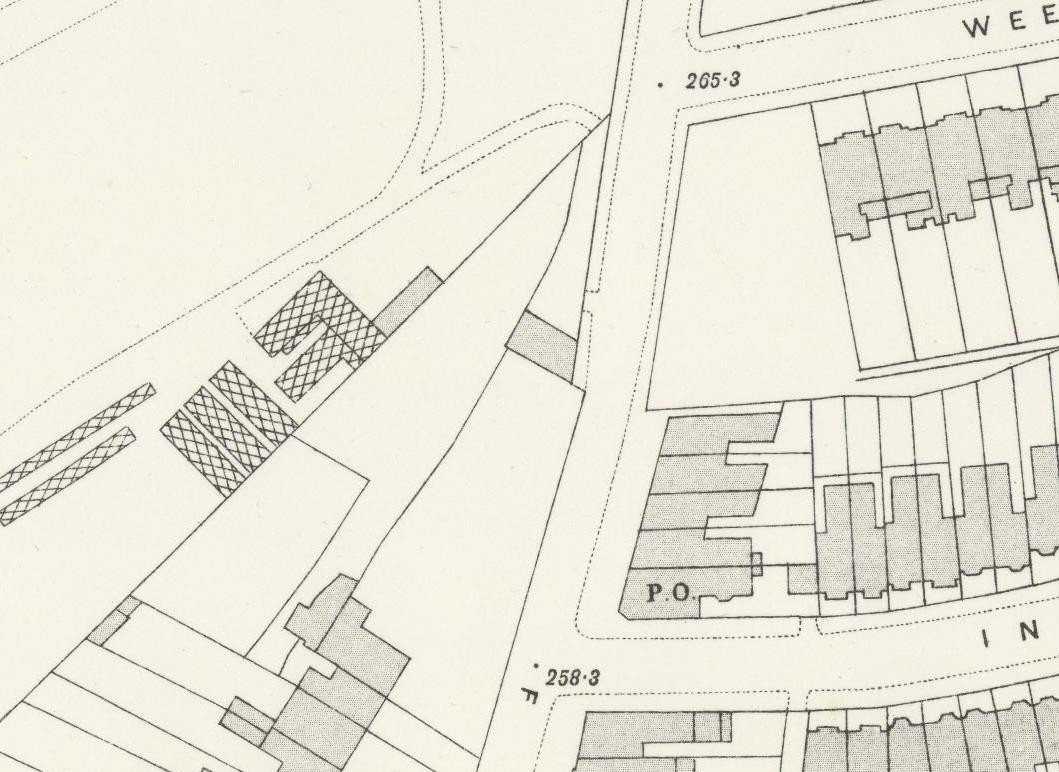

In [86]:
from pigeon import annotate
from IPython.display import display, Image

annotations = annotate(
  map_tiles,
  options=['building', 'no_building'],
  display_fn=lambda filename: display(Image(filename))
)

In [ ]:
annotations

In [ ]:
import pickle 

In [ ]:
with open('annotations.pkl', 'wb') as annotations_dump:
    pickle.dump(annotations, annotations_dump)

In [ ]:
with open('annotations.pkl','rb') as annotations_file:
    annotations = pickle.load(annotations_file)

In [ ]:
annotations

In [ ]:
labels_dict = dict(annotations)

In [ ]:
labels_dict['slices_64/126515555.27_02_01_02_03.jpg']

In [ ]:
func = lambda x: labels_dict[str(x)]

In [ ]:
building_data = (ImageList.from_folder('slices_64') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)
        .label_from_func(func)
        .transform(size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())        

In [ ]:
building_data

In [ ]:
building_data.show_batch()

In [ ]:
learn = cnn_learner(building_data, models.resnet34, metrics=accuracy)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-02)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
building_data_2 = (ImageList.from_folder('slices_64') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)
        .label_from_func(func)
        .transform(size=128)       #Data augmentation? -> use tfms with a size of 64
        .databunch())

In [ ]:
learn.data = building_data_2

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-02)

In [ ]:
building_data_3 = (ImageList.from_folder('slices_64') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)
        .label_from_func(func)
        .transform(size=256)       #Data augmentation? -> use tfms with a size of 64
        .databunch())     

In [ ]:
learn.data = building_data_3

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-02)

In [ ]:
building_data_4 = (ImageList.from_folder('slices_64') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.3)
        .label_from_func(func)
        .transform(size=512)       #Data augmentation? -> use tfms with a size of 64
        .databunch())     

In [ ]:
learn.data = building_data_4

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-02)

In [ ]:
learn

In [ ]:
Image.MAX_IMAGE_PIXELS = None
image = '117917133.27.tif'

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

In [ ]:
img

In [ ]:
def predict_tiles(image):
    tiles = image_slicer.slice(image, 64, save=False)
    for tile in tiles:
        img = open_image(tile.image)
        pred_class,pred_idx,outputs = learn.predict(img)
        print(pred_class,pred_idx)
#predict_tiles('117917133.27.tif')

In [ ]:
import numpy as np
image = '117917133.27.tif'
tiles = image_slicer.slice(image, 32, save=False)
for tile in tiles:
    #print(type(tile.image))
    x = np.array(tile.image)
  #  x = np.random.randn(3, 256, 256)
    img = Image(torch.from_numpy(x).float())
    learn.predict(img)


In [ ]:
new_map = '117917133.27.tif'

In [ ]:
def slice_map(image):
    fname = Path(image).stem
    tiles = image_slicer.slice(image, 32, save=False)
    image_slicer.save_tiles(tiles, prefix=fname, directory='test', format='jpeg')


In [ ]:
slice_map(new_map)

In [ ]:
test_tiles = glob.glob('test/*.jpg')

In [ ]:
for tile in test_tiles:
    img = open_image(tile)
    pred_class,pred_idx,outputs = learn.predict(img)
    print(tile)
    print(pred_class,pred_idx,outputs)
    print('------------------')

In [ ]:
# predicting on a tensor 

img = pil2tensor(img, np.float32)
img = Image(img)
pred = learn.predict(img)

In [ ]:
def predict_tiles(image):
    tiles = image_slicer.slice(image, 64, save=False)
    for tile in tiles:
        img = pil2tensor(tile.image, np.float32)
        img = Image(img)
        pred = learn.predict(img)
        print(pred)